In [27]:
# Library Imports

# Standard Libraries 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# MongoDB
from pymongo import MongoClient

## Import Parameters from Topic_Extractor_Params.dat

In [28]:
def param_loader(file):
    '''A loader definition for loading script dependant parameters'''
    
    fileObj = open(file, mode='r')

    params = {}

    for line in fileObj:
        line = line.strip()
        
        key_value = line.split('=')
        
        if len(key_value) == 2:
            params[key_value[0].strip()] = key_value[1].strip()
            
    return params

In [29]:
## Assign Params from .dat ##

topic_params = param_loader('Topic_Extractor_Params.dat')
mongo_params = param_loader('../Scraper_Params.dat')

## Cleaner Params ##

fix_unicode       = bool(int(topic_params['Fix Unicode']))
lowercase         = bool(int(topic_params['All Lowercase']))
no_accents        = bool(int(topic_params['Remove Accents']))
no_contradictions = bool(int(topic_params['Remove Contradictions']))
no_emails         = bool(int(topic_params['Remove Emails']))
no_newline        = bool(int(topic_params['Remove Newline']))
no_punctuation    = bool(int(topic_params['Remove Punctuation']))
no_currency       = bool(int(topic_params['Replace Currency']))

## Stop Words ##

added_stop_words  = topic_params['Added Stop Words'].split(' ')

## Query Params ##

n_hours           = int(topic_params['Time Frame in Hours'])
red_or_blue       = str(topic_params['Red, Blue or All'])
n_topics          = int(topic_params['Number of Topics'])
model             = str(topic_params['Model'])

## Spacy Params ##

spacy_model       = str(topic_params['Spacy Model'])
min_word_length   = int(topic_params['Min Word Length'])
use_cleaned       = bool(int(topic_params['Use Cleaned Text']))
split_columns     = bool(int(topic_params['Split Columns']))
named_entities    = topic_params['Named Entity List'].split(' ')

## Mongo Params ##

mongo_host        = str(mongo_params['mongodb_host'])
mongo_port        = int(mongo_params['mongodb_port'])

## TFIDF Params ## 

column            = str(topic_params['Column to Vectorize'])
normalize         = bool(int(topic_params['Normalize']))
sublinear_tf      = bool(int(topic_params['Sublinear TF']))
smooth_idf        = bool(int(topic_params['Smooth IDF']))
vocabulary        = topic_params['Vocabulary']
min_df            = float(topic_params['Min DF'])
max_df            = float(topic_params['Max DF'])
min_ic            = float(topic_params['Min IC'])

if bool(int(topic_params['Use IDF'])):
    weighting     = 'tfidf'
else:
    weighting     = 'tf'

if topic_params['Max Terms'] == '0':
    max_n_terms   = None
else:
    max_n_terms   = int(topic_params['Max Terms'])

## Import Database from Mongo

In [30]:
client = MongoClient(host=mongo_host, port=mongo_port)

db = client.Politiprocess

collection = db.reddit_posts

In [31]:
query = {'is article': True}

if n_hours == 0:
    print(f"Pulling all articles from {red_or_blue} targets.")
else:
    print(f"Pulling {red_or_blue} articles from last {n_hours} hours.")
    dt = datetime.utcnow() - timedelta(hours=n_hours)
    query['date'] = {'$gt': dt}

if red_or_blue == 'Red':
    query['target'] = True
    
elif red_or_blue == 'Blue':
    query['is article'] = False
    
else:
    pass
    
df = pd.DataFrame(list(collection.find(query)))  

del query

print(f"Completed pulling {len(df)} articles.  Latest article is from {str(collection.find_one(sort=[('date', -1)])['date'])} GMT.")

Pulling Red articles from last 24 hours.
Completed pulling 54 articles.  Latest article is from 2018-04-20 05:46:58 GMT.


## Preprocessing

In [32]:
import textacy
import spacy

In [33]:
cleaned = [] 
for x in range(len(df)):
    text = textacy.preprocess.preprocess_text(df.text[x],
                                        fix_unicode=fix_unicode,
                                        lowercase=lowercase,
                                        no_punct=no_punctuation,
                                        no_contractions=no_contradictions,
                                        no_currency_symbols=no_currency,
                                        no_emails=no_emails,
                                        no_accents=no_accents)
    if no_newline:
        text = text.replace('\n', ' ') 
    
    cleaned.append(text)

df['cleaned'] = cleaned
del cleaned

In [34]:
print(f"Loading Spacy Model {spacy_model}.  This could take a while...")

nlp = spacy.load(spacy_model)

print("Complete")

Loading Spacy Model en_core_web_md.  This could take a while...
Complete


In [35]:
print(f"Adding {len(added_stop_words)} custom stop words to Spacy Model.")

from spacy.lang.en.stop_words import STOP_WORDS

for stop_word in added_stop_words:
    STOP_WORDS.add(stop_word)
    
print(f"Complete. There are {len(STOP_WORDS)} stop words in the list.")

Adding 20 custom stop words to Spacy Model.
Complete. There are 316 stop words in the list.


In [36]:
def spacy_processing(use_cleaned, split_columns):  
    
    if use_cleaned:
        corpus    = 'cleaned'
        df_column = 'cleaned'
    else:
        corpus    = 'raw'
        df_column = 'text'   
    
    print(f'''Filtering stops and words shorter than {min_word_length + 1} letters. 
Chunking and identifying {named_entities} entities from {corpus} corpus.''')    
    
    chunks_list = []
    ents_list   = []
    
    for text in df[df_column]:
        
        doc = nlp(str(text))
        
        chunks = []
        ents   = []
        
        for span in doc.noun_chunks:
            if len(span) == 1:
                if span[0].is_stop or len(span[0]) <= min_word_length:
                    continue
                else:
                    chunks.append(span.text)
                    continue
            else:
                chunks.append(span.text)
        
        for ent in doc.ents:
            if ent.label_ in named_entities:
                ents.append(ent.text)
                
        chunks_list.append(chunks)
        ents_list.append(ents)
    
    if split_columns:
        df['chunks'], df['ents'] = chunks_list, ents_list
        del chunks_list, ents_list
        print(f"Done inserting {len(df.chunks.sum())} chunks and {len(df.ents.sum())} entities into df.chunks and df.ents.")
    else:
        joined_list = [a + b for a, b in zip(chunks_list, ents_list)]
        del chunks_list, ents_list
        df['chunks_ents'] = joined_list
        del joined_list
        print(f"Done inserting {len(df.chunks_ents.sum())} chunks and entities into df.chunks_ents.)")
    
spacy_processing(use_cleaned, split_columns)

Filtering stops and words shorter than 3 letters. 
Chunking and identifying ['PERSON', 'GPE', 'ORG', 'NORP'] entities from cleaned corpus.
Done inserting 11663 chunks and entities into df.chunks_ents.)


In [37]:
print(f"Loading Vectorizer Paramaters")
vocabulary=None
vectorizer = textacy.vsm.Vectorizer(weighting, normalize, sublinear_tf,
                                    smooth_idf, vocabulary, min_df, max_df,
                                    min_ic, max_n_terms)

Loading Vectorizer Paramaters


In [38]:
print(f"Fitting Vectorizor on {column} column")
doc_term_matrix = vectorizer.fit_transform(df[column])

Fitting Vectorizor on chunks_ents column


topic 0 : Imran   Minhas   Pakistan   Awans   Haji   the Awans   TheDCNF   Pakistani   Rehman Malik   USB
topic 1 : A renewed GOP   the Republican Party   Republican Party   The Republican Party   change   Paul Ryan   a Republican Party   Republicans   Americans   America
topic 2 : Hatfill   Weissman   Fitzgerald   Mueller   AIPAC   Berger   Libby   Stevens   the FBI   Enron
topic 3 : Chinese   Illinois   UIUC   party cells   China   the University   Spain   Greece   Portugal   Italy
topic 4 : Weinstein   Harvey   Hollywood   Ben   Harvey Weinstein   Brad   Hillary   Bill   course   Michelle
topic 5 : Manafort   Mueller   Rosenstein   Jackson   Dreeben   Russia   Trump   DOJ   Russian   the criminal case
topic 6 : Moon   North Korea   Kim   South Korea   Pyongyang   Seoul   Korean   Kim Jong Un   South Korean   the United States
topic 7 : Liberty   Patriots   our flag   American Patriots   yard signs   religion   bumper stickers   philosophy   a friend   Patriots' Day
topic 8 : Peterso

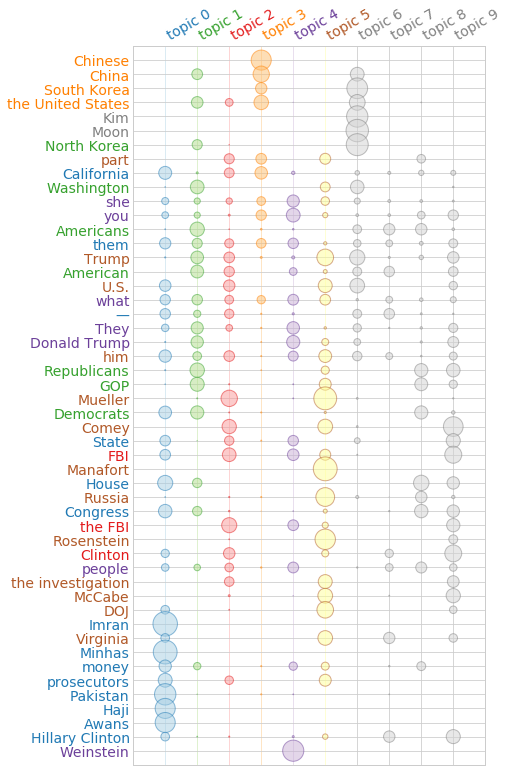

In [39]:
model = textacy.tm.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)

topics_string = ""

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    topics_string += ' '.join(top_terms) + ' '
    print('topic', topic_idx, ':', '   '.join(top_terms))
    
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=50, sort_terms_by='seriation')

In [ ]:
from wordcloud import WordCloud

In [ ]:
topics_string

In [ ]:
wordcloud = WordCloud().generate(topics_string)

In [ ]:
wordcloud = WordCloud(max_font_size=80, width = 800, height=400).generate(topics_string)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

In [ ]:
len(vectorizer.id_to_term)

In [ ]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4],
                   topics=-1,  n_terms=40, sort_terms_by='seriation')

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
for x in doc:
    x.ent_iob_

In [ ]:
for x in doc:
    print()

In [ ]:
STOP_WORDS

In [ ]:
for x in doc.noun_chunks:
    if x.text.lower() not in STOP_WORDS:
        print(x)

In [ ]:
texts = [] 
for x in range(len(df)):
    texts.append(textacy.preprocess.preprocess_text(df.text[x],
                                                    fix_unicode=False,
                                                    lowercase=True,
                                                    no_punct=True,
                                                    no_contractions=True,
                                                    no_currency_symbols=True,
                                                    no_emails=True,
                                                    no_accents=True,
                                                   ))

df.cleaned = texts
texts = []

In [ ]:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS.union(["device medium caption", 
                                            "medium", "caption", 
                                            "playback", "unsupported",
                                            "said", " 's", "'s","", " ", "  ","''", "week"])

In [ ]:
for term in stop_words:
    STOP_WORDS.add(term)

In [ ]:
corpus = textacy.corpus.Corpus(lang='en', texts=list(df.cleaned))

In [ ]:
for x in corpus[0].tokens:
    print(x.is_stop)

In [ ]:
terms_list = (docs.to_terms_list(ngrams=(1,2,3), named_entities=False, as_strings=True, filter_stops=True, filter_punct=True) for docs in corpus)

In [ ]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=False, smooth_idf=True, 
                        min_df=.01, max_df=.99, max_n_terms=None)

doc_term_matrix = vectorizer.fit_transform(terms_list)
doc_term_matrix.shape

In [ ]:
model = textacy.tm.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print(top_terms)

In [ ]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=100, sort_terms_by='seriation')

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,3), min_df = 2, stop_words = stop_words, max_features=None)

In [ ]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df['cleaned'])

In [ ]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

In [ ]:
len(tfidf_vectorizer.get_feature_names())

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
lda = LatentDirichletAllocation(n_components=20, n_jobs=-1, max_iter=10, learning_method='batch')

In [ ]:
lda_matrix = lda.fit_transform(document_term_matrix_df)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(lda, tfidf_vectorizer.get_feature_names(), 10)

## LSA

In [ ]:
n_components = 10
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [ ]:
svd_matrix = SVD.fit_transform(document_term_matrix_df)

In [ ]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                        index=document_term_matrix_df.index,
                                        columns=component_names)

In [ ]:
latent_semantic_analysis

In [ ]:
vocabulary_loadings = pd.DataFrame(SVD.components_,
                                   index=component_names,
                                   columns=tfidf_vectorizer.get_feature_names()).T

In [ ]:
vocabulary_loadings.sort_values('component_5', 0, ascending=False)

In [ ]:
for component in vocabulary_loadings:
    print(component + ' - ' + vocabulary_loadings[component].idxmax())

In [ ]:
n_components = 100
X = list(range(5, n_components))
e_v_s = []

tfidf_vectorizer = TfidfVectorizer(min_df = 5, stop_words = stop_words)
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df['cleaned'])

for x in range(5,n_components):
    n_components = x
    SVD = TruncatedSVD(n_components)
    svd_matrix = SVD.fit_transform(document_term_matrix_df)
    e_v_s.append(SVD.explained_variance_ratio_.sum())
    
plt.plot(X, e_v_s)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
X = latent_semantic_analysis.drop('target', axis=1)
y = latent_semantic_analysis['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .1,)

In [ ]:
ks = list(range(1,25))
train_accuracies = []
test_accuracies = []

for k in ks:
    knc = KNeighborsClassifier(n_neighbors=k, n_jobs = -1)
    knc.fit(X_train, y_train)
    train_score = knc.score(X_train, y_train)
    test_score = knc.score(X_test, y_test)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)

In [ ]:
plt.plot(ks, train_accuracies, c='g', label='train')
plt.plot(ks, test_accuracies, c='b', label='test')
plt.axvline(np.argmax(test_accuracies)+1, label='optimal_k')
plt.legend()

In [ ]:
knc = KNeighborsClassifier(n_neighbors=np.argmax(test_accuracies)+1, n_jobs = -1)
knc.fit(X_train, y_train)
train_score = knc.score(X_train, y_train)
test_score = knc.score(X_test, y_test)
print(train_score, test_score)

## Logistic Regression

In [ ]:
log = LogisticRegression(C=100)
log.fit(X_train,y_train)

In [ ]:
log.score(X_train,y_train), log.score(X_test,y_test)

# Spacy

In [ ]:
doc = nlp(article_title_list[0])
doc.is_parsed

In [ ]:
import spacy
from collections import Counter
nlp = spacy.load('en')

# all tokens that arent stop words or punctuations
words = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
nouns = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(5)

# five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(5)

In [ ]:
# all tokens that arent stop words or punctuations
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

In [ ]:
words

In [ ]:
# noun tokens that arent stop words or punctuations
nouns = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

In [ ]:
for x in doc.doc:
    print(x)

In [ ]:
num = 0
# doc = nlp(article_text_list[0])
for num, entity in enumerate(doc.ents):
    print(f'Entity {num + 1}', entity, '-', entity.label_)

In [ ]:
def punct_space(token):
    return token.is_punct or token.is_space

def article_reader(df):
    for article in df.cleaned:
        yield article.replace("\n\n", "\n")

def lemmatized_sentence_corpus(document):
    for parsed_article in nlp.pipe(document, batch_size = 100000, n_threads = 4):
        
        for sent in parsed_article.sents:
            yield ' '.join([token.lemma_ for token in sent if not punct_space(token)])

In [ ]:
for sent in lemmatized_sentence_corpus(article_reader(df)):
    print(sent)

# Textacy

In [ ]:
import spacy
import textacy
from spacy import displacy

In [ ]:
df = list(collection.find({'is article': True}, {'_id': 0, 'comments':0}))

In [ ]:
texts = []
metadatas = [] 
for x in range(len(df)):
    texts.append(textacy.preprocess.preprocess_text(df[x].pop('text'),
                                                    fix_unicode=True,
                                                    no_contractions=True,
                                                    no_currency_symbols=True,
                                                    no_emails=True,
                                                    no_numbers=True,
                                                   ))
    metadatas.append(df[x])
df = []

In [ ]:
corpus = textacy.corpus.Corpus(lang='en', texts=texts, metadatas=metadatas)

In [ ]:
nlp = spacy.load(name='en')

In [ ]:
doc = corpus[1]

In [ ]:
doc_nlp = nlp(doc.text)

In [ ]:
displacy.render(doc_nlp, style='ent', jupyter=True)

In [ ]:
terms_list = (docs.to_terms_list(ngrams=3, normalize='lemma', lemmatize=True,
                                 named_entities=True, as_strings=True, filter_stops=True)for docs in corpus)

In [ ]:
terms_list

In [ ]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=False, smooth_idf=True, 
                        min_df=.01, max_df=.99, max_n_terms=1000)

doc_term_matrix = vectorizer.fit_transform(terms_list)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
vectorizer.id_to_term

In [ ]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

In [ ]:
model.termite_plot(vocabulary_loadings, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=100, sort_terms_by='seriation')

## Gensim

In [ ]:
stopWords = set(stopwords.words('english'))

In [ ]:
corpus = 

In [ ]:
tfidf = models.TfidfModel(corpus)

# TextBlob

In [ ]:
for article_title in df['article title']:
    print(article_title, TextBlob(article_title).sentiment, TextBlob(article_title).np_counts)

In [ ]:
all_titles = ""
for article_title in df['article title']:
    all_titles += '. ' + article_title

In [ ]:
all_titles

In [ ]:
article_title = TextBlob(df['article title'][1])
article_title

In [ ]:
all_titles_blob = TextBlob(all_titles)

In [ ]:
for sentence in all_titles_blob.sentences:
    print(sentence, sentence.np_counts, sentence.sentiment)

In [ ]:
for text in red_topic_list['post title']:
    blob = TextBlob(text)
    print(text, blob.sentiment_assessments, "\n")

In [ ]:
# NLP Libraries
from nltk.corpus import stopwords

import textacy

import spacy

from textblob import TextBlob

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# Visualization
import matplotlib.pyplot as plt
from spacy import displacy
import pyLDAvis
import pyLDAvis.gensim
import warnings

%matplotlib inline